<a href="https://colab.research.google.com/github/wmex91/PhD-Manufacturing-CausalNet-v1/blob/main/causal_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing causalnex
!pip install causalnex

In [ ]:
# Installing Pygraphviz - NOT WORKING ON COLAB
!pip install Pygraphviz

In [ ]:
# Installing paddlepaddle-gpu - BTW is not working
!pip install paddlepaddle-gpu

In [ ]:
# Importing GDrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/My Notebooks/PhD Notebooks/Colab-Manufacturing-Model-Learning/Causal-Manufacturing-Learning-v1
%ls
# Alternative: /content/drive/GDrive/Colab Notebooks/My Notebooks/PhD Notebooks/Colab-Manufacturing-Model-Learning/Causal-Manufacturing-Learning-v1


In [2]:
# Importing libraries
import os
import time
import datetime
import networkx
import pandas
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image

In [10]:
# Preparing the data set
# Setting the csv path 
CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/My Notebooks/PhD Notebooks/'\
'Colab-Manufacturing-Model-Learning/Causal-Manufacturing-Learning-v1/dataset/' \
'2022.02.23-11.55-log/merged_logs.csv'


# Getting the dataframe from the file
data = pandas.read_csv(CSV_PATH, delimiter=',')

data.head(10)

,step,input Machine A,time process Machine A,output Machine A,produced Machine A,failure Machine A,MTTF Machine A,repair time Machine A,Machine A flag,input Machine B,time process Machine B,output Machine B,produced Machine B,failure Machine B,MTTF Machine B,repair time Machine B,Machine B flag,input Machine C,time process Machine C,output Machine C,produced Machine C,failure Machine C,MTTF Machine C,repair time Machine C,Machine C flag
0,0.0,200,0,0,0,0,86400,0,0,200,0,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
1,0.1,200,0,0,0,0,86400,0,0,200,0,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
2,1.0,200,0,0,0,0,86400,0,0,200,0,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
3,1.1,200,0,0,0,0,86400,0,0,200,0,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
4,1.5,199,0,0,0,0,86400,0,0,199,0,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
5,1.6,199,261,0,0,0,86400,0,0,199,237,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
6,2.0,199,261,0,0,0,86400,0,0,199,237,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
7,2.1,199,261,0,0,0,86400,0,0,199,237,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
8,3.0,199,261,0,0,0,86400,0,0,199,237,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0
9,3.1,199,261,0,0,0,86400,0,0,199,237,0,0,0,86400,0,0,0,0,0,0,0,100800,0,0


In [ ]:
print(data.dtypes)
print(data.columns)

In [11]:
# Splitting the "step" column into "step" and "moment" in 3 steps:
# 1. Converting the step col into string type
data['step_str'] = data['step'].astype(str)
data.dtypes

step                      float64
input Machine A             int64
time process Machine A      int64
output Machine A            int64
produced Machine A          int64
failure Machine A           int64
MTTF Machine A              int64
repair time Machine A       int64
Machine A flag              int64
input Machine B             int64
time process Machine B      int64
output Machine B            int64
produced Machine B          int64
failure Machine B           int64
MTTF Machine B              int64
repair time Machine B       int64
Machine B flag              int64
input Machine C             int64
time process Machine C      int64
output Machine C            int64
produced Machine C          int64
failure Machine C           int64
MTTF Machine C              int64
repair time Machine C       int64
Machine C flag              int64
step_str                   object
dtype: object

In [12]:
# Splitting the "step" column into "step" and "moment" in 3 steps:
# 1. Converting the step col into string type
data["step_str"] = data["step"].astype(str)
# 2. Using str.split to split the col at the "."
data[["step", "moment"]] = data.step_str.str.split(".", expand = True)
# 3. Dropping the temp col
data.drop(columns=["step_str"], inplace=True)

# Reordering the result
data = data[["step", "moment", "failure Machine A", "Machine A flag", 
      "failure Machine B",  "Machine B flag", "failure Machine C", 
      "Machine C flag"]]

# Converting everything in int 
data = data.astype(int)

print(data)

            step  moment  ...  failure Machine C  Machine C flag
0              0       0  ...                  0               0
1              0       1  ...                  0               0
2              1       0  ...                  0               0
3              1       1  ...                  0               0
4              1       5  ...                  0               0
...          ...     ...  ...                ...             ...
1271874  1036795       0  ...                  0               0
1271875  1036796       0  ...                  0               0
1271876  1036797       0  ...                  0               0
1271877  1036798       0  ...                  0               0
1271878  1036799       0  ...                  0               0

[1271879 rows x 8 columns]


In [13]:
# Dropping the unneccessary columns
data.drop(columns=["step", "moment"], inplace=True)
print(data)

         failure Machine A  Machine A flag  ...  failure Machine C  Machine C flag
0                        0               0  ...                  0               0
1                        0               0  ...                  0               0
2                        0               0  ...                  0               0
3                        0               0  ...                  0               0
4                        0               0  ...                  0               0
...                    ...             ...  ...                ...             ...
1271874                  0               0  ...                  0               0
1271875                  0               0  ...                  0               0
1271876                  0               0  ...                  0               0
1271877                  0               0  ...                  0               0
1271878                  0               0  ...                  0               0

[12

In [ ]:
# Dropping the unneccessary columns - DEPRECATO COL NUOVO IMPLEMENT
data.drop(columns=["step", "moment", "input Machine A", "time process Machine A", 
                   "output Machine A", "produced_x", "MTTF Machine A", 
                   "repair time Machine A"], inplace=True)

data.drop(columns=["step", "moment", "input Machine B", "time process Machine B", 
                   "output Machine B", "produced_y", "MTTF Machine B", 
                   "repair time Machine B"], inplace=True)

data.drop(columns=["step", "moment", "input Machine C", "time process Machine C", 
                   "output Machine C", "produced", "MTTF Machine C", 
                   "repair time Machine C"], inplace=True)

# Printing the head
print(data)

In [14]:
# Saving the light dataset into csv
LIGHT_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/My Notebooks/' \
'PhD Notebooks/Colab-Manufacturing-Model-Learning/' \
'Causal-Manufacturing-Learning-v1/dataset/2022.02.23-11.55-log/'\
'light-logs.csv'

data.to_csv(LIGHT_CSV_PATH)

In [32]:
# Getting tabu child nodes
tabu_child_list = [x for x in data.columns if 'failure' in x]

print('Tabu child list: ', tabu_child_list)

# Training the model
# Declaring and mining the structure of the causal-net
start_time = time.time()
structure_model = from_pandas(data)
finish_time = time.time()
sim_time = finish_time - start_time

# Printing the structure model with Python
print("Total training time: {} min, {} secs".format(round(sim_time/60, 0), 
                                                    round(sim_time%60, 2)))
# print("Total training time: {} seconds".format(round(sim_time, 2)/60))
print(structure_model)

Tabu child list:  ['failure Machine A', 'failure Machine B', 'failure Machine C']
Total training time: 6.0 min, 1.41 secs
StructureModel with 6 nodes and 30 edges


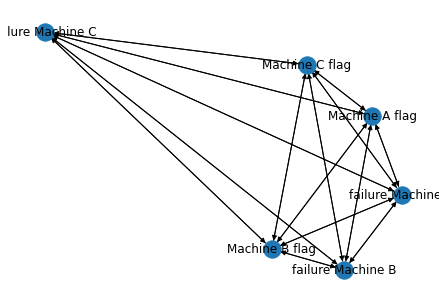

In [33]:
# Printing the structure model with networkx
networkx.draw(structure_model, with_labels=True)

In [ ]:
# Che fa? boooh - SALTA
# networkx.drawing.nx_pydot.write_dot(structure_model, 'graph.dot')

StructureModel with 6 nodes and 0 edges


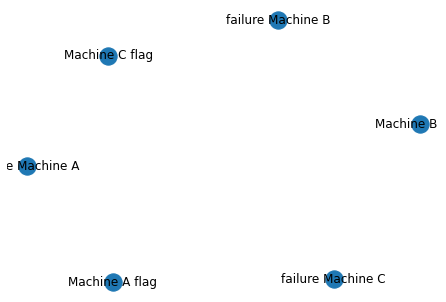

In [44]:
pruned_model = structure_model
pruned_model.remove_edges_below_threshold(1)
print(pruned_model)
# Printing the structure model again
networkx.draw(pruned_model, with_labels=True)

In [ ]:
structure_model.edges(data = 'weight')

OutEdgeDataView([('failure Machine A', 'Machine A flag', 2.7715694218996015e-05), ('failure Machine A', 'failure Machine B', 0.00020922468593406835), ('failure Machine A', 'Machine B flag', 0.001953806689328719), ('failure Machine A', 'failure Machine C', 1.2049577208074912e-09), ('failure Machine A', 'Machine C flag', 2.7317863199992057e-07), ('Machine A flag', 'failure Machine A', 0.9508586072009347), ('Machine A flag', 'failure Machine B', 0.00012052221996857689), ('Machine A flag', 'Machine B flag', 0.0008195288437936076), ('Machine A flag', 'failure Machine C', 1.4647760694649468e-07), ('Machine A flag', 'Machine C flag', 2.0822863219248003e-05), ('failure Machine B', 'failure Machine A', 0.005051513331800862), ('failure Machine B', 'Machine A flag', 0.06015708949189389), ('failure Machine B', 'Machine B flag', 2.0604316371111073e-05), ('failure Machine B', 'failure Machine C', -4.715912856297664e-11), ('failure Machine B', 'Machine C flag', 2.470505479252935e-05), ('Machine B fla